In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.tabular.all import *
from wwf.tab.export import *

In [3]:
from bnbsl import *

In [4]:
SEASON = '22'
set_seed(int(SEASON))

## Data preparation

In [5]:
path = Path()
path_data = Path('data')

In [6]:
df = pd.read_csv(path_data/'data.csv', dtype={'HC':'float', 'AC':'float'}, parse_dates=['Date'])

In [7]:
div = ['E0', 'E1', 'E2', 'D1', 'D2', 'SP1', 'SP2', 'I1', 'I2', 'F1', 'F2']
df = df[(df.Div.isin(div)) & (df.Season >= 18) & (df.Season <= 22)]

# Drop NA corner
df = df.dropna().reset_index(drop=True)

In [8]:
add_datepart(df, 'Date');

In [9]:
# Time-weighted
df['weight'] = np.exp(-(df.Elapsed.max() - df.Elapsed) / (3600*24*365) / df.Year.nunique())
df['weight'] = df['weight'] / df['weight'].mean()

In [10]:
procs = [Categorify, FillMissing, Normalize]

In [11]:
valid_idx = list(df.query('Season == 22').index)

In [12]:
splitter = IndexSplitter(valid_idx)
splits = splitter(range_of(df))

In [13]:
splits

((#17000) [0,1,2,3,4,5,6,7,8,9...],
 (#50) [2437,2438,2439,2440,2441,2442,2443,2444,2445,2446...])

In [14]:
y_names = ['HC', 'AC']
cat_names = ['Div', 'HomeTeam', 'AwayTeam']
# cont_names = list(df.columns[df.columns.str.contains('Avg')])

In [15]:
cont_names = [
    'HSLast5Avg', 
    'HCLast5Avg', 
    'ASLast5Avg', 
    'ACLast5Avg', 
    'HomeSForLast5Avg', 
    # 'HomeCForLast5Avg', 
    'AwaySForLast5Avg', 
    # 'AwayCForLast5Avg',
    'HomeSAgainstLast5Avg', 
    # 'HomeCAgainstLast5Avg', 
    'AwaySAgainstLast5Avg', 
    # 'AwayCAgainstLast5Avg',
]

In [16]:
y_block = RegressionBlock(n_out=2)

In [17]:
df.sample(10)

,Div,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HC,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,weight
6355,E2,Shrewsbury,Sunderland,0.0,2.0,16.0,6.0,2.0,4.0,6.0,...,5,293,False,False,False,False,False,False,1.539994e+09,0.683782
4473,E1,Sheffield United,Millwall,1.0,1.0,14.0,13.0,2.0,7.0,10.0,...,5,103,False,False,False,False,False,False,1.555114e+09,0.752597
404,D1,Wolfsburg,Leverkusen,0.0,2.0,9.0,9.0,1.0,4.0,9.0,...,6,314,False,False,False,False,False,False,1.573344e+09,0.844839
6936,E2,Peterboro,Burton,1.0,0.0,9.0,11.0,4.0,3.0,7.0,...,5,327,False,False,False,False,False,False,1.574467e+09,0.850878
8175,E2,Sunderland,Gillingham,1.0,0.0,25.0,5.0,5.0,0.0,8.0,...,5,92,False,False,False,False,False,False,1.648858e+09,1.363827
14810,SP1,Valladolid,Cadiz,1.0,1.0,13.0,6.0,6.0,2.0,5.0,...,5,114,False,False,False,False,False,False,1.619222e+09,1.130149
14666,SP1,Alaves,Sevilla,1.0,2.0,12.0,7.0,3.0,3.0,3.0,...,1,19,False,False,False,False,False,False,1.611014e+09,1.072824
6984,E2,Peterboro,Doncaster,0.0,3.0,18.0,9.0,4.0,4.0,4.0,...,3,360,False,False,False,False,False,False,1.577318e+09,0.866404
13572,I2,Pordenone,Cittadella,0.0,1.0,17.0,14.0,3.0,6.0,6.0,...,1,46,False,False,False,False,False,False,1.644883e+09,1.329881
6950,E2,Coventry,Ipswich,1.0,1.0,15.0,6.0,4.0,1.0,5.0,...,5,341,False,False,False,False,False,False,1.575677e+09,0.857431


In [18]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block, splits=splits)

In [19]:
to.cat_names, to.cont_names

((#3) ['Div','HomeTeam','AwayTeam'],
 (#8) ['HSLast5Avg','HCLast5Avg','ASLast5Avg','ACLast5Avg','HomeSForLast5Avg','AwaySForLast5Avg','HomeSAgainstLast5Avg','AwaySAgainstLast5Avg'])

In [20]:
display_df(to.xs.iloc[-2:])

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg
11089,7,195,209,-0.176956,-1.050251,0.034847,-0.234145,0.071018,-0.075796,-0.875684,-0.662803
11090,7,223,182,-0.248348,0.200983,0.349489,0.827463,-0.379282,0.220777,-0.802670,-0.146066


### To other packages (e.g. Scikit-learn, LightGBM, XGBoost)

In [21]:
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, XGBRFRegressor

In [22]:
X_train, y_train = to.train.xs, to.train.ys.values
X_test, y_test = to.valid.xs, to.valid.ys.values

In [23]:
X_train.shape, y_train.shape

((17000, 11), (17000, 2))

In [24]:
X_test.shape, y_test.shape

((50, 11), (50, 2))

## LightGBM

In [25]:
fit_params = {'feature_name':list(X_test.columns), 'categorical_feature':cat_names}

In [26]:
m_lgbm = MultiOutputRegressor(LGBMRegressor(objective='poisson', n_estimators=100, n_jobs=-1, reg_lambda=1.0))
m_lgbm.fit(X_train, y_train, **fit_params)

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


MultiOutputRegressor(estimator=LGBMRegressor(objective='poisson',
                                             reg_lambda=1.0))

In [27]:
import lightgbm as lgbm

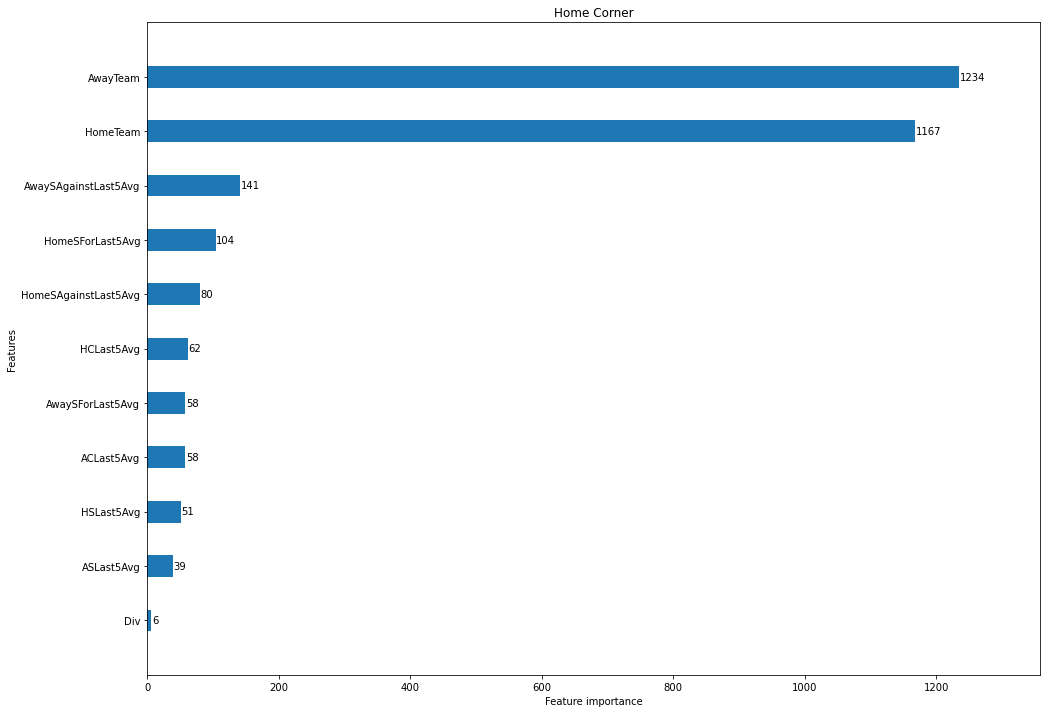

In [28]:
lgbm.plot_importance(m_lgbm.estimators_[0], figsize=(16, 12), title='Home Corner', max_num_features=40, height=0.4, grid=False);

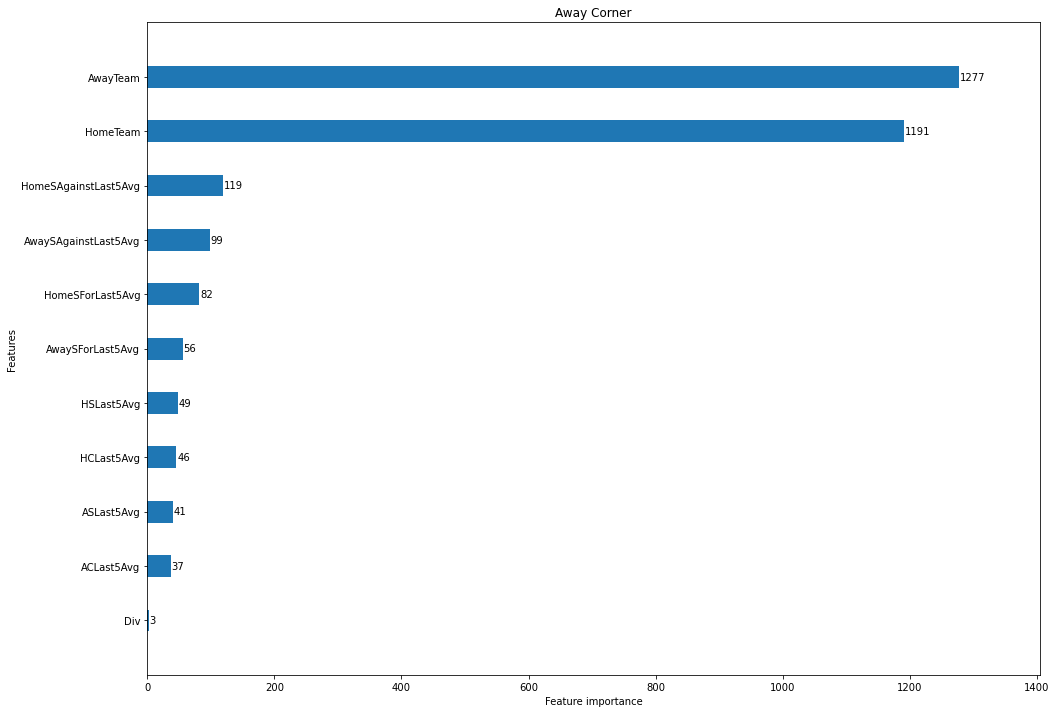

In [29]:
lgbm.plot_importance(m_lgbm.estimators_[1], figsize=(16, 12), title='Away Corner', max_num_features=40, height=0.4, grid=False);

## XGBoost

In [30]:
m_xgb = MultiOutputRegressor(XGBRegressor(objective='count:poisson', n_estimators=100, n_jobs=-1, tree_method='exact'))
m_xgb.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            objective='count:poisson',
                                            rand

In [31]:
import xgboost as xgb

In [32]:
for i in range(0, 2):
    m_xgb.estimators_[i].get_booster().feature_names = list(X_test.columns)

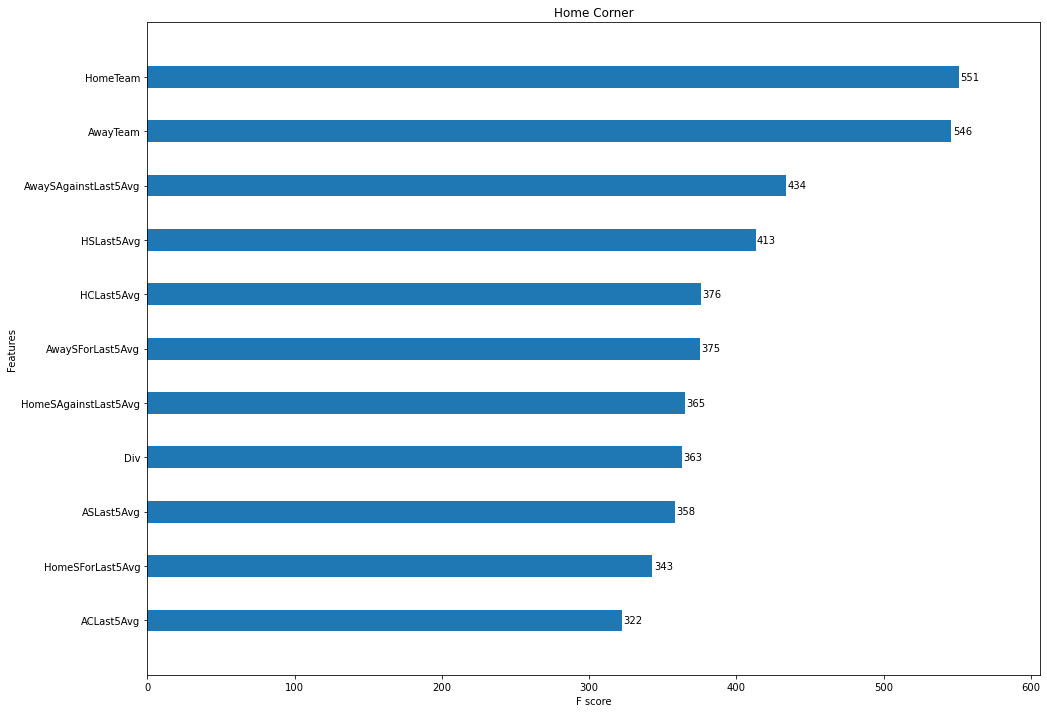

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
xgb.plot_importance(m_xgb.estimators_[0], title='Home Corner', max_num_features=40, height=0.4, grid=False, ax=ax);

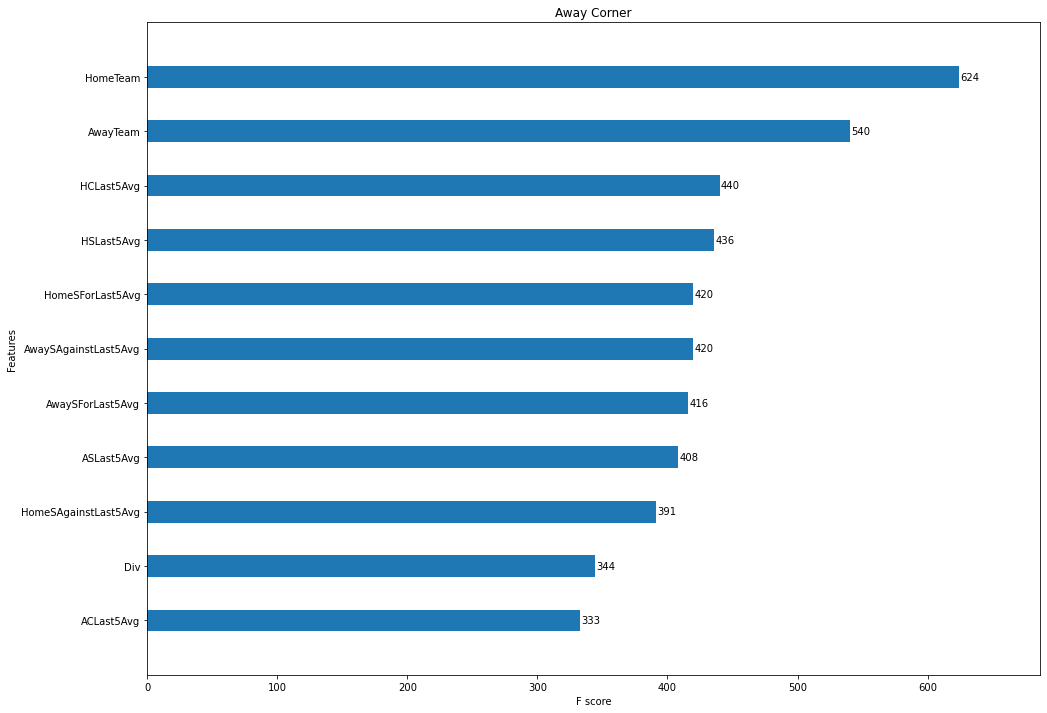

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
xgb.plot_importance(m_xgb.estimators_[1], title='Away Corner', max_num_features=40, height=0.4, grid=False, ax=ax);

## Poisson

In [35]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg,HC,AC
0,E2,Wycombe,Morecambe,16.799999,5.8,9.6,3.6,11.800000,9.400000,14.4,16.000000,9.0,2.0
1,F2,Chambly,Caen,11.400000,4.2,9.6,3.6,13.200000,8.600000,8.4,14.600000,0.0,4.0
2,SP1,Ath Bilbao,Huesca,13.400000,6.0,11.0,3.6,10.400000,10.400000,10.6,12.000000,5.0,5.0
3,F2,Valenciennes,Dunkerque,10.400000,5.2,8.8,3.8,10.000000,10.000000,13.2,14.200000,9.0,2.0
4,E1,Leeds,Brentford,14.600000,5.4,13.6,6.2,16.200001,16.200001,9.0,11.600000,2.0,3.0
5,D1,Hertha,Union Berlin,11.200000,4.2,11.2,4.0,14.600000,12.200000,15.8,14.000000,4.0,6.0
6,F2,Amiens,Grenoble,8.400000,4.8,7.6,2.0,9.800000,9.600000,8.8,11.800000,3.0,1.0
7,E1,Wycombe,Birmingham,11.600000,4.6,9.0,3.0,12.600000,9.400000,15.8,11.400000,4.0,7.0
8,E2,Wycombe,Rochdale,10.200000,3.8,11.6,3.4,11.000000,11.600000,14.4,16.799999,7.0,5.0
9,SP1,Celta,Ath Madrid,8.400000,3.4,12.0,6.2,7.600000,14.800000,14.0,9.400000,2.0,5.0


In [36]:
learn = tabular_learner(dls, layers=[240, 120])

In [37]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(270, 37)
    (2): Embedding(271, 37)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=88, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=2, bias=True)
    )
  )
)

In [38]:
learn.loss_func = BaseLoss(partial(nn.PoissonNLLLoss, log_input=True, full=True), floatify=True)

SuggestedLRs(valley=0.0010000000474974513)

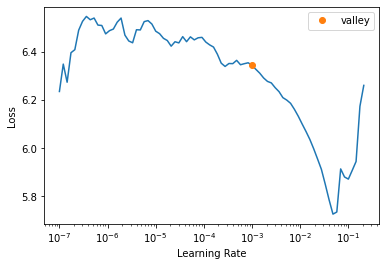

In [39]:
learn.lr_find()

In [40]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,2.578652,2.493869,00:02
1,2.406489,2.477181,00:02
2,2.372872,2.305468,00:01
3,2.337426,2.308926,00:01
4,2.291861,2.282641,00:01


In [41]:
df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')[['HC', 'AC']]

,HC,AC
3604,3.0,11.0


In [42]:
_, _, params = learn.predict(df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')
                               .drop(columns=y_names).iloc[0])

In [43]:
pois_corner_home = torch.distributions.poisson.Poisson(params[0].exp())
pois_corner_away = torch.distributions.poisson.Poisson(params[1].exp())

In [44]:
print(pois_corner_home.mean, pois_corner_home.variance)
print(pois_corner_away.mean, pois_corner_away.variance)

tensor(4.0340) tensor(4.0340)
tensor(6.4643) tensor(6.4643)


In [45]:
corner_home = pois_corner_home.log_prob(torch.arange(0., 15.)).exp()
corner_away = pois_corner_away.log_prob(torch.arange(0., 15.)).exp()
corner = torch.ger(corner_home, corner_away)
mask = torch.zeros_like(corner)

In [46]:
mask = torch.zeros_like(corner)
line = 10.5
for i in range(0, mask.size()[0]):
    for j in range(0, mask.size()[1]):
        if i + j < line: mask[i, j] = 1. 

In [47]:
prob_lo = (corner * mask).sum()
prob_hi = 1 - prob_lo

In [48]:
prob_lo, prob_hi

(tensor(0.5209), tensor(0.4791))

## Negative Binomial

In [49]:
y_names = ['HC', 'AC', 'weight']
y_block = RegressionBlock(n_out=5)

In [50]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block, splits=splits)

In [51]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg,HC,AC,weight
0,I2,Salernitana,Frosinone,11.200000,4.6,9.8,4.4,6.200000,11.8,11.6,12.0,3.0,7.0,0.828791
1,E1,Preston,Barnsley,9.000000,5.0,10.6,5.8,7.600000,13.0,10.8,13.8,5.0,2.0,0.828337
2,E0,Arsenal,Leicester,8.000000,5.0,14.0,5.8,8.200000,9.8,11.8,12.6,9.0,3.0,1.023442
3,I2,Vicenza,Spal,13.400000,4.6,14.0,6.4,14.000000,10.4,11.2,15.4,5.0,6.0,1.091801
4,I1,Atalanta,Empoli,16.600000,8.4,7.4,3.0,16.799999,12.6,8.2,21.4,15.0,2.0,1.400941
5,E1,Bristol City,Middlesbrough,11.400000,4.4,9.6,4.0,11.400000,11.4,13.8,11.2,1.0,4.0,1.020642
6,E2,Peterboro,Wigan,12.800000,4.4,8.8,5.2,12.800000,8.0,7.0,13.0,5.0,5.0,1.095997
7,F2,Dunkerque,Dijon,5.600000,2.8,10.6,3.6,8.200000,13.2,11.8,11.8,3.0,6.0,1.337921
8,I2,Benevento,Ascoli,19.799999,7.8,11.6,3.8,16.400000,13.4,12.6,13.0,5.0,6.0,1.330610
9,SP1,Getafe,Ath Bilbao,11.200000,3.0,14.2,6.6,10.200000,13.6,12.0,11.2,5.0,3.0,1.279136


In [52]:
learn_bnb = tabular_learner(dls, layers=[240, 120], n_out=5)

In [53]:
learn_bnb.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(270, 37)
    (2): Embedding(271, 37)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=88, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=5, bias=True)
    )
  )
)

In [54]:
learn_bnb.loss_func = BivariateNegativeBinomialSLNLLLoss()
learn_bnb.loss_func

BivariateNegativeBinomialSLNLLLoss()

SuggestedLRs(valley=0.015219217166304588)

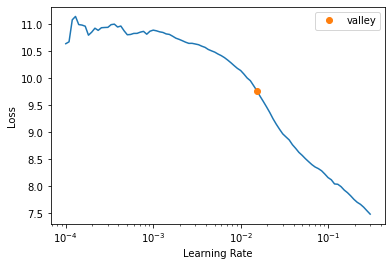

In [55]:
learn_bnb.lr_find(start_lr=1e-04, end_lr=5e-01)

In [56]:
learn_bnb.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,time
0,4.911408,6.691597,00:01
1,4.708570,6.613573,00:01
2,4.657244,6.570437,00:01
3,4.628536,6.533812,00:01
4,4.620907,6.547113,00:01


In [57]:
df.query('Season==21 and HomeTeam=="Chelsea" and AwayTeam=="Man City"')[['HC', 'AC']]

,HC,AC
3646,4.0,13.0


In [58]:
def predict(self, row):
    "Predict on a Pandas Series"
    dl = self.dls.test_dl(row.to_frame().T)
    dl.dataset.conts = dl.dataset.conts.astype(np.float32)
    inp,preds,_ = self.get_preds(dl=dl, with_input=True, with_decoded=False)
    b = tuplify(inp)
    full_dec = self.dls.decode(b)
    return full_dec,preds[0]

learn_bnb.predict = MethodType(predict, learn_bnb)

In [59]:
_, params = learn_bnb.predict(df.query('Season==21 and HomeTeam=="Chelsea" and AwayTeam=="Man City"')
                                .drop(columns=y_names).iloc[0])

In [60]:
params

tensor([ -2.0891,  -2.6066,   3.5358,   6.2823, -47.4942])

In [61]:
alpha = F.softplus(params[0:2])
mu = F.softplus(params[2:4])
omega = params[4]
# omega = torch.tanh(params[4]) * 50.

total_count = 1. / alpha
logits = torch.log(alpha * mu)

print(alpha, mu, omega)

tensor([0.1167, 0.0712]) tensor([3.5645, 6.2842]) tensor(-47.4942)


In [62]:
bnb_corner = BivariateNegativeBinomialSL(total_count=total_count, omega=omega, logits=logits)

In [63]:
print(bnb_corner.mean, bnb_corner.variance)

tensor([3.5645, 6.2842]) tensor([5.0475, 9.0955])


In [64]:
# Method 1:
corr = omega * torch.sqrt(mu.prod()) * alpha.prod() / ((1.+alpha)**(1./alpha+1.)).prod() / torch.sqrt((1.+alpha*mu).prod())
corr 

tensor(-0.1612)

In [65]:
# Method 2:
# d = 1.-math.exp(-1)
# corr = omega * d**2 * torch.sqrt(mu.prod()*(1.+alpha*mu).prod()) * ((1.+d*alpha*mu)**(-1-1/alpha)).prod()
# corr 

In [66]:
value = torch.cartesian_prod(torch.arange(0., 15.), torch.arange(0., 15.))

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


In [67]:
corner = bnb_corner.log_prob(value).exp()

In [68]:
line = 10.5
mask = value.sum(-1) < line
prob_lo = corner[mask].sum()
prob_hi = 1 - prob_lo

In [69]:
prob_lo, prob_hi

(tensor(0.6014), tensor(0.3986))

In [70]:
1/prob_lo, 1/prob_hi

(tensor(1.6628), tensor(2.5087))

### Train full model

In [71]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block)

In [72]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg,HC,AC,weight
0,I1,Juventus,Chievo,13.4,8.0,8.2,2.2,12.2,7.4,6.800000,10.6,12.0,5.0,0.719530
1,E1,Millwall,Stoke,13.6,8.0,13.8,5.6,13.4,13.4,10.600000,11.6,0.0,10.0,1.248666
2,SP2,Las Palmas,Oviedo,9.8,3.6,6.6,2.4,9.6,8.4,7.800000,9.2,9.0,3.0,1.026812
3,SP2,Extremadura UD,Zaragoza,12.0,4.6,10.4,4.4,9.2,15.0,16.799999,10.8,1.0,2.0,0.764232
4,SP1,Osasuna,Sevilla,12.2,5.0,10.8,3.8,13.2,11.4,10.400000,10.4,1.0,1.0,1.322614
5,E2,Plymouth,Bristol Rvs,13.6,7.8,9.6,3.6,12.4,9.4,12.000000,10.8,8.0,9.0,0.743986
6,SP1,Valladolid,Sociedad,12.0,8.4,9.2,5.0,10.4,14.4,14.200000,11.2,7.0,5.0,0.747255
7,I2,Cittadella,Crotone,13.4,5.4,8.6,4.6,14.4,10.6,11.600000,14.8,2.0,4.0,1.211596
8,SP1,Celta,Sociedad,11.6,5.4,8.8,5.2,8.4,15.0,17.600000,11.8,2.0,7.0,0.750126
9,E2,Burton,Peterboro,12.0,4.8,10.8,4.0,13.4,12.8,11.400000,9.0,2.0,10.0,1.100209


In [73]:
learn_bnb = tabular_learner(dls, layers=[240, 120], n_out=5)

In [74]:
learn_bnb.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(270, 37)
    (2): Embedding(271, 37)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=88, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=5, bias=True)
    )
  )
)

In [75]:
learn_bnb.loss_func = BivariateNegativeBinomialSLNLLLoss()
learn_bnb.loss_func

BivariateNegativeBinomialSLNLLLoss()

SuggestedLRs(valley=0.013976634480059147)

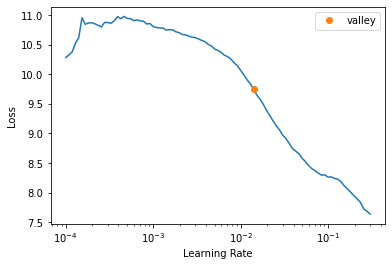

In [76]:
learn_bnb.lr_find(start_lr=1e-04, end_lr=5e-01)

In [77]:
learn_bnb.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,time
0,4.839004,None,00:02
1,4.692624,None,00:02
2,4.673406,None,00:02
3,4.643893,None,00:02
4,4.587652,None,00:02


/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [78]:
learn_bnb.export('models/learn_bnbsl.pkl')

In [79]:
to.export('models/to.pkl')

### t-SNE

In [80]:
df['HomeTeam'].astype('category').cat.categories.values

array(['AFC Wimbledon', 'Accrington', 'Ajaccio', 'Ajaccio GFCO', 'Alaves',
       'Albacete', 'Alcorcon', 'Alessandria', 'Almeria', 'Amiens',
       'Amorebieta', 'Angers', 'Arsenal', 'Ascoli', 'Aston Villa',
       'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Auxerre',
       'Barcelona', 'Barnsley', 'Bastia', 'Bayern Munich', 'Benevento',
       'Betis', 'Beziers', 'Bielefeld', 'Birmingham', 'Blackburn',
       'Blackpool', 'Bochum', 'Bologna', 'Bolton', 'Bordeaux',
       'Bournemouth', 'Bradford', 'Braunschweig', 'Brentford', 'Brescia',
       'Brest', 'Brighton', 'Bristol City', 'Bristol Rvs', 'Burgos',
       'Burnley', 'Burton', 'Cadiz', 'Caen', 'Cagliari', 'Cambridge',
       'Cardiff', 'Cartagena', 'Castellon', 'Celta', 'Chambly',
       'Charlton', 'Chateauroux', 'Chelsea', 'Cheltenham', 'Chievo',
       'Cittadella', 'Clermont', 'Como', 'Cordoba', 'Cosenza', 'Coventry',
       'Cremonese', 'Crewe', 'Crotone', 'Crystal Palace', 'Darmstadt',
       'Derby', 'Dijon', 'D

In [81]:
df['AwayTeam'].astype('category').cat.categories.values

array(['AFC Wimbledon', 'Accrington', 'Ajaccio', 'Ajaccio GFCO', 'Alaves',
       'Albacete', 'Alcorcon', 'Alessandria', 'Almeria', 'Amiens',
       'Amorebieta', 'Angers', 'Arsenal', 'Ascoli', 'Aston Villa',
       'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Auxerre',
       'Barcelona', 'Barnsley', 'Bastia', 'Bayern Munich', 'Benevento',
       'Betis', 'Beziers', 'Bielefeld', 'Birmingham', 'Blackburn',
       'Blackpool', 'Bochum', 'Bologna', 'Bolton', 'Bordeaux',
       'Bournemouth', 'Bradford', 'Braunschweig', 'Brentford', 'Brescia',
       'Brest', 'Brighton', 'Bristol City', 'Bristol Rvs', 'Burgos',
       'Burnley', 'Burton', 'Cadiz', 'Caen', 'Cagliari', 'Cambridge',
       'Cardiff', 'Cartagena', 'Castellon', 'Celta', 'Chambly',
       'Charlton', 'Chateauroux', 'Chelsea', 'Cheltenham', 'Chievo',
       'Cittadella', 'Clermont', 'Como', 'Cordoba', 'Cosenza', 'Coventry',
       'Cremonese', 'Crewe', 'Crotone', 'Crystal Palace', 'Darmstadt',
       'Derby', 'Dijon', 'D

In [82]:
variable = 'HomeTeam'
ix = cat_names.index(variable)

var_vals = list(df[variable].astype('category').cat.categories.values)
nval = len(var_vals)
print(f'Number of values: {nval}')
print(var_vals)

Number of values: 269
['AFC Wimbledon', 'Accrington', 'Ajaccio', 'Ajaccio GFCO', 'Alaves', 'Albacete', 'Alcorcon', 'Alessandria', 'Almeria', 'Amiens', 'Amorebieta', 'Angers', 'Arsenal', 'Ascoli', 'Aston Villa', 'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Auxerre', 'Barcelona', 'Barnsley', 'Bastia', 'Bayern Munich', 'Benevento', 'Betis', 'Beziers', 'Bielefeld', 'Birmingham', 'Blackburn', 'Blackpool', 'Bochum', 'Bologna', 'Bolton', 'Bordeaux', 'Bournemouth', 'Bradford', 'Braunschweig', 'Brentford', 'Brescia', 'Brest', 'Brighton', 'Bristol City', 'Bristol Rvs', 'Burgos', 'Burnley', 'Burton', 'Cadiz', 'Caen', 'Cagliari', 'Cambridge', 'Cardiff', 'Cartagena', 'Castellon', 'Celta', 'Chambly', 'Charlton', 'Chateauroux', 'Chelsea', 'Cheltenham', 'Chievo', 'Cittadella', 'Clermont', 'Como', 'Cordoba', 'Cosenza', 'Coventry', 'Cremonese', 'Crewe', 'Crotone', 'Crystal Palace', 'Darmstadt', 'Derby', 'Dijon', 'Doncaster', 'Dortmund', 'Dresden', 'Duisburg', 'Dunkerque', 'Eibar', 'Ein Frankfurt

In [83]:
# import altair as alt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

emb_mx = to_np(next(learn_bnb.model.embeds[ix].parameters()))
#X_emb = TSNE(n_components=2, perplexity=3).fit_transform(emb_mx)
#X_emb = PCA(n_components=2).fit_transform(emb_mx)
annotation = np.append('Other', np.array(var_vals))

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' 

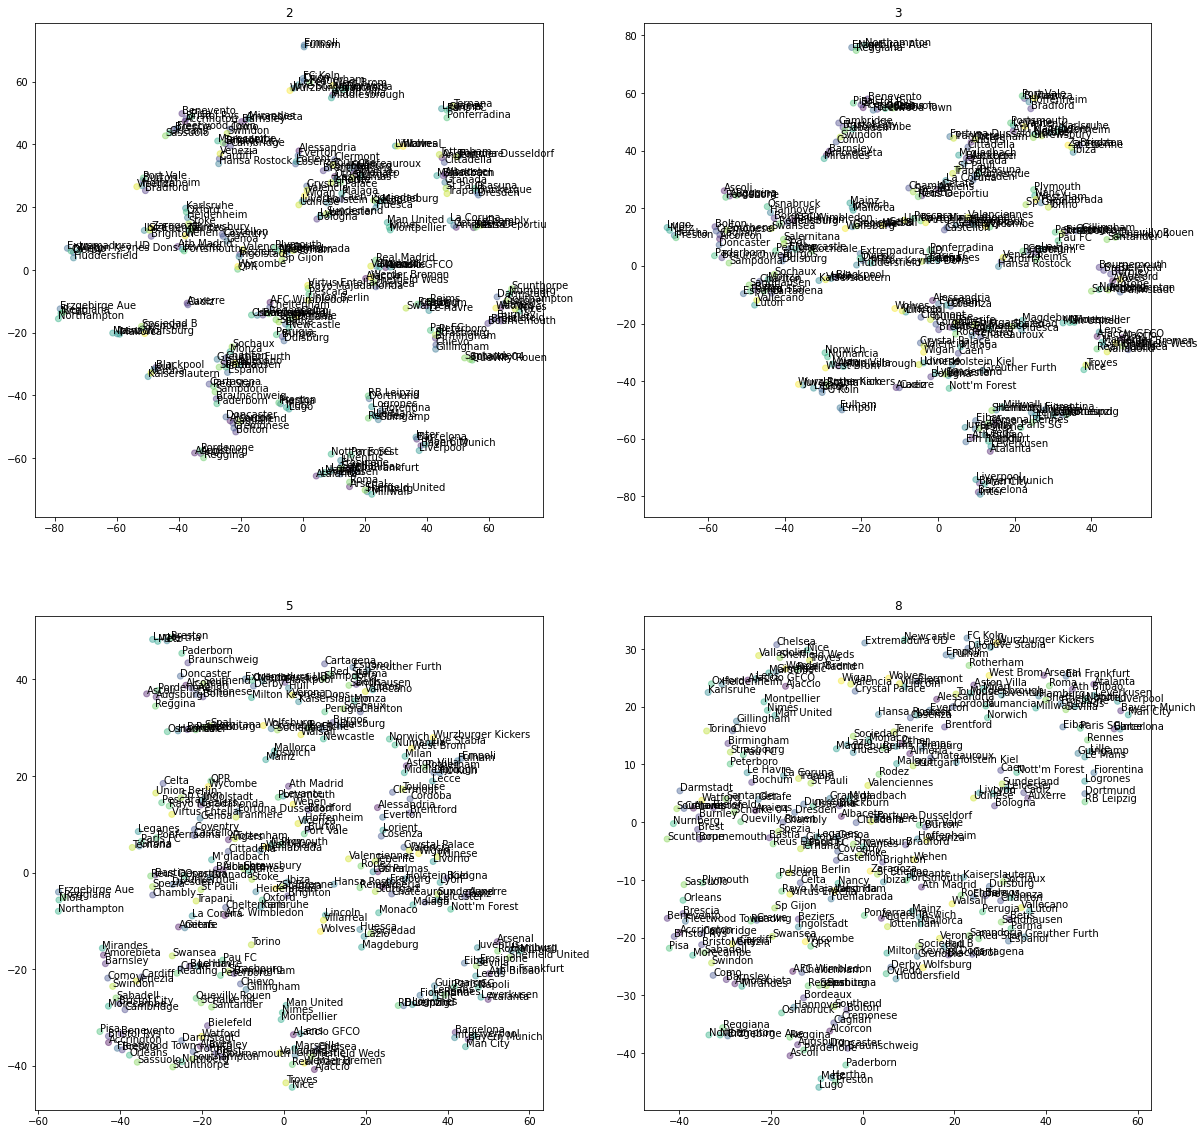

In [84]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(20)
fig.set_figwidth(20)

perplexity = [2, 3, 5, 8]
for ax,perp in zip(axes.flatten(), perplexity):
    X_emb = TSNE(n_components=2, perplexity=perp).fit_transform(emb_mx)
    ax.scatter(X_emb[:,0], X_emb[:,1], c=range(len(annotation)), alpha=0.4)
    for xy,target in zip(X_emb, annotation):
        if isinstance(target, np.str_) or isinstance(target, str):
            text = target
        else:
            text = "%d" % target
        ax.annotate(text=text, xy=(xy[0], xy[1]))
        ax.set_title(perp)

# END